# Transpired

This starter code incorporates transient ET. 

## 1. Setup the environment

In [2]:
#the basics
import flopy
import numpy as np
import matplotlib as mp
import os

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

#jupyter specific--included to show plots in notebook
%matplotlib inline 

## 2. Create the model object

In [3]:
modelname = "Transient"
moddir = "C:/Users/tento/Documents/GW_Modeling/homework-akahler03/Working/mf2005.exe"
m = flopy.modflow.Modflow(modelname, exe_name = moddir)
#moddir = os.getcwd()+"\\modflowdir\\mf2005.exe"


In [4]:
#optional delete old run files
run = 'n'
if run == 'y':
    file_extensions = ['.dis','.bas','.lpf','.oc','.pcg','.wel']
    #file_extensions = ['.dis','.bas','.bcf','.oc','.pcg', '.wel', 'rch']
    for ext in file_extensions:
        os.remove(modelname + ext)

## 3. Setup the discretization (DIS package)

For more details on DIS package inputs refer to : https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfdis.html 

#### 3.1 Spatial discretization

In [5]:
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 1  #number of layers

dx= 10 #width of grid cells in x direction 
dy= 10 #width of grid cells in y direction 

Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

ztop = 50.    #top elevation 
zbot = 0.     #bottom elevation

dz = (ztop - zbot) / nlay #cell height in z direction

domain_centerpt = (0, int(nrow/2), int(ncol/2))   # used for plotting

#### 3.2 Temporal discretization 

These are the added variables for the transient simulation. 
- **nper** is the number of  model stress periods.
- The **steady** variable turns into a list with boolean entries "True/False" for each of these stress periods. The first is designated as "True" in order to set up a steady-state solution for our aquifer to use as a base for future transient stress periods. (If we just start solving transient stress periods with arbitrary starting heads, it wouldn't make for a very realistic natural groundwater system.) More stress periods are added to a simulation if there are changes to the "stress" on the aquifer, i.e. pumping, river levels, or recharge rates. (Note: some things cannot be changed per stress period, i.e. ibound, conductivity, or other properties related to the aquifer geology.)
- **perlen** designates the length of each stress period. For the steady-state stress period, it doesn't really matter what we assign here since the equation is not time-dependent. For the transient stress periods we assign 'perlen' entries that correspond to whatever we have defined our length units to be.
- **nstp** is the number of steps for which MODFLOW's solver will attain solutions within the length of each stress periods. It may be adjusted depending on what you are interested in resolving in the simulation; if you wish to see high resolution changes in head profiles, a higher nstp may be used. However, this will increase the time required to solve the simulation since the solver needs to output more solutions, so if you are just interested in the general head behavior over a large number of stress periods, a lower 'nstp' may be used.

In [6]:
sp_peryr = 2        # periods for seasonality (two stress periods per year)
sp1_len = 90       # Length of stress period 1 in days
sp2_len = 360-sp1_len      # Length of stress period 2 in days
sim_years = 10       #number of years for transient simulation 
nper = int(sp_peryr*sim_years + 1) # total number of stress periods the +1 is for the steady state start

#setup the steady state array
steady = np.ones(nper, dtype=bool)*False     # steady-state or transient flag for each stress period (boolean array)
steady[0] = True    # initial stress period is steady-state

#make an array of period lengths
perlen=np.tile([sp1_len, sp2_len],sim_years)
perlen=np.append(10,perlen) #add a period of length 10 at the start for the steady state simulation

nstp=perlen/30 # set monthly time steps per stress period to get monthly results
nstp[0]=1 #for the steady state solution we just want one output
nstp = nstp.astype(int)

elyears = (np.cumsum(perlen)-perlen[0])/360

print("Period lengths", perlen)
print("Number of Steps", nstp)
print(np.sum(nstp))

Period lengths [ 10  90 270  90 270  90 270  90 270  90 270  90 270  90 270  90 270  90
 270  90 270]
Number of Steps [1 3 9 3 9 3 9 3 9 3 9 3 9 3 9 3 9 3 9 3 9]
121


In [7]:
print(nper)

21


#### 3.3 Create DIS object

In [8]:
#create flopy discretization object, length and time are meters (2) and days (4)
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady, perlen=perlen, nstp=nstp)

#### 3.4 Plot the grid

For help on this function see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.plot.plotutil.html

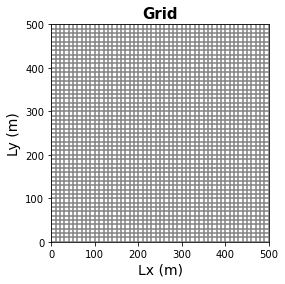

In [9]:
#use flopy to plot the grid of model 'm'
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid() 
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Grid', fontsize = 15, fontweight = 'bold')
plt.show()

## 4. Setup constant head boundaries, active cells and initial heads (BAS Package)

For more details on the BAS package see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfbas.html

#### 4.1 Define cell activity: IBOUND 

In [10]:
#create ibound as array of ints = 1
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active     

#set constant head boundary on the left
ibound[:,:,0] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head 
ibound[:,:,-1] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head 

#print("ibound values: \n", ibound)

#### 4.2 Define starting heads 

In [11]:
#setup initial heads as 1 everywhere and 7 on the left boundary 
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_left = 50 # Left boundary constant head value
H_right = 30  # Right boundary constant head value
H_init[:, :, 0] = H_left  # replace first (left) col with desired head value
H_init[:, :, -1] = H_right  # replace first (left) col with desired head value

#print("starting head values: \n", H_init)


#### 4.3 Create BAS object

In [12]:
#create flopy bas object
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#### 4.4 Plot the grid and ibound

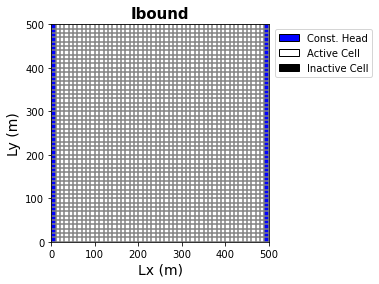

In [13]:
#plot grid and ibound
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.5,1.0))
plt.show(modelmap)

## 5. Setup Layer Properties (LPF or BCF packages)

There are two packages that can be used for the **LPF** and **BCF**. They are very similar but have some different options for layer types and controling connections between layers. 

- For more details on LPF package see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mflpf.html
- For more details on BCF package see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfbcf.html
  
Note that both are setup below but only one is actually being called. 

#### 5.1 Set layer properties
Setting up arrays for the K field and they layer type

**NOTE: Layer type options differ between the LPF anc BCF packages**

In [14]:
K_vals = np.zeros((nlay, nrow, ncol))
K_vals[:, :, :] = 1    # horizontal K values
K_vert = 1     #Either the value of hvertical K or the ratio of horizontal to vertical K (refer to documentation_)

n = 0.35        #assign porosity
Ss = 0.001      #assign storage coefficient
Sy = 0.3        #assign specific yield
laytype = 1       #0=confined, >0 = convertible (for the LPF file)


#### 5.2 Plot the K field

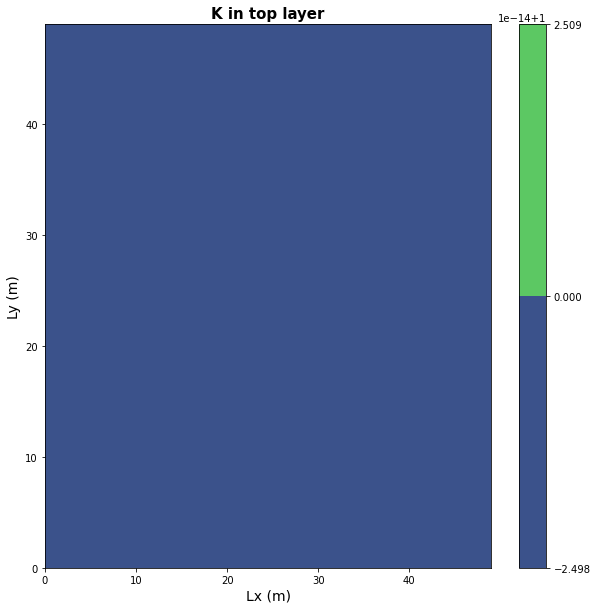

In [15]:
#plot K values in top layer
fig1 = plt.figure(figsize=(10, 10))  # create 10 x 10 figure
plt.xlabel('Lx (m)', fontsize=14)
plt.ylabel('Ly (m)', fontsize=14)
plt.title('K in top layer', fontsize=15, fontweight='bold')
plt.contourf(np.flipud(K_vals[0, :, :]))
plt.colorbar()
plt.show()

#### 5.3a  Make LPF object

In [16]:
#assigns horizontal and vertical Ks and saves cell-by-cell budget data
lpf = flopy.modflow.ModflowLpf(m, laytyp=laytype, hk=K_vals, 
                                vka=K_vert, ss=Ss,
                                sy=Sy,storagecoefficient=True, ipakcb=53) 


#### 5.3.b Make BCF object

In [17]:
#assigns horizontal and vertical Ks and saves cell-by-cell budget data
#bcf = flopy.modflow.ModflowBcf(m, ipakcb=53, intercellt=0, laycon=3, trpy=1.0, hdry=-1e+30, iwdflg=0, wetfct=0.1, iwetit=1, ihdwet=0, tran=1.0, hy=K_vals[0,:,:], vcont=1.0, sf1=Ss, sf2=Sy, wetdry=-0.01, extension='bcf', unitnumber=None, filenames=None) 


## 6. Setup outputs by stress period (OC Package)
For more details on OC Package: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfoc.html

#### 6.1 Setup outputs

In [18]:
#create oc stress period data - save for each time step in each stress period. 
oc_spd = {}
for kper in range(nper):  
    for kstp in range(nstp[kper]):
        #print(kstp)
        oc_spd[(kper, kstp)] = ['save head','save drawdown','save budget','print head','print budget']

print(nstp)
#print("oc stress period data: \n", oc_spd)

[1 3 9 3 9 3 9 3 9 3 9 3 9 3 9 3 9 3 9 3 9]


#### 6.2 Make OC object 

In [19]:
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=oc_spd, compact=True)

## 7. Set the numerical solver (PCG Package)

We are using the Preconditioned Conjugate Gradient package:

Additionally, MODFLOW online describes these solvers: https://water.usgs.gov/ogw/modflow/MODFLOW-2005-Guide/index.html?oc.htm

And Flopy documents its communication with the PCG MODFLOW package: http://modflowpy.github.io/flopydoc/mfpcg.html

#### 7.1 Make the PCG object

In [20]:
pcg = flopy.modflow.ModflowPcg(model=m)

## 8. Add wells for the constant flux boundary (WEL Package)
For more details on the WEL package see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfwel.html

#### 8.1 Setup the well parameters (use this to set a defined flux boundary)

In [21]:
#Setup alternating pumping values
well_loc = [0, 20, 20]
Q1 = -500 # pumping for stress period 1 [m3/day]
Q2 = 0   #pumping rate for stress period 2 [m3/day]
Q_val=np.tile([Q1, Q2],sim_years)
Q_val=np.append(0,Q_val) # 0 pumping period for the initial stead state solution

# create empty dictionary for well info
well_spd = {}       
# Loop over stress periods to assign well stresses
for per in range(nper):    
    well_spd[per] = [[well_loc[0], well_loc[1], well_loc[2], Q_val[per]]]     # assign well coord & pump rate for each stress period

print(well_spd)


{0: [[0, 20, 20, 0]], 1: [[0, 20, 20, -500]], 2: [[0, 20, 20, 0]], 3: [[0, 20, 20, -500]], 4: [[0, 20, 20, 0]], 5: [[0, 20, 20, -500]], 6: [[0, 20, 20, 0]], 7: [[0, 20, 20, -500]], 8: [[0, 20, 20, 0]], 9: [[0, 20, 20, -500]], 10: [[0, 20, 20, 0]], 11: [[0, 20, 20, -500]], 12: [[0, 20, 20, 0]], 13: [[0, 20, 20, -500]], 14: [[0, 20, 20, 0]], 15: [[0, 20, 20, -500]], 16: [[0, 20, 20, 0]], 17: [[0, 20, 20, -500]], 18: [[0, 20, 20, 0]], 19: [[0, 20, 20, -500]], 20: [[0, 20, 20, 0]]}


#### 8.2 Make the WEL object

In [22]:
wel = flopy.modflow.mfwel.ModflowWel(m, stress_period_data=well_spd)  #create object for WEL package

## 9. Add recharge (RCH Package)

For more details on the recharge package see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfrch.html

#### 9.1 Setup transient recharge value

In [23]:
#Recharge 
rech_zone = np.zeros((nrow,ncol))               #define an array of zeros of dim (nrow,ncol)
recharge = 1                   # a value of 1 allows us to broadcast the desired values in loop  #m/day      
rech_zone[:, :] = recharge

rch1 = 5e-4
rch2 = 0

RH_val=np.tile([rch1,rch2],sim_years)
RH_val=np.append(0,RH_val) #add a period of length 10 at the start for the steady state simulation

RH = {}

for p in range(0,nper):
    RH[p] = rech_zone * RH_val[p] #stress period 1 to 4

rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=RH, ipakcb=53)     #create rch object


#### 9.2 Add evapotranspiration
For more details on the evapotranspiraiton package see the flopy and modflow documentation: 
- https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfevt.html 
- https://water.usgs.gov/ogw/modflow/MODFLOW-2005-Guide/index.html?evt.htm 
- https://pubs.usgs.gov/tm/2005/tm6A16/PDF.htm (refer to chapter 6)



In [24]:
#ET
ET_val1 = 1e-3 #m/day durring the 3 months the well is onn
ET_val2 = 0 #m/day durring the 9 months the well is off

ET_zone = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid
bkgndET = 1 #set background ET value m/day   # changed to 1 for ET[p] loop
#ET_zone = ET_zone + bkgndET  #apply background ET to the entire domain 
ET_zone[:,10:30,10:30] = ET_val1 # for when we only want ET in a box around well
extinction_depth = 20

#Setup alternating ET values
ET_val=np.tile([ET_val1, ET_val2],sim_years)
ET_val=np.append(0,ET_val) #add a zero ET for the steady state simulation
                      
ET = {}
for p in range(0,nper):    #loop over stress periods
    ET[p]=ET_zone*ET_val[p]   # inour case, ET_val is really of interest, not ET_zone in general

#print(len(ET))
evt = flopy.modflow.mfevt.ModflowEvt(model=m, surf=ztop, evtr=ET, exdp=extinction_depth, ipakcb=53) # where it calls the module in python, throws error below if off


#### Specify which scenario to save figs for


In [25]:
challenge = 'Transient Recharge'

## 10. Write inputs and run the model 

#### 10.1 Write Inputs

In [26]:
m.write_input()    #uses the package objects created above to actually write the text files, 
                    #and saves to folder that this script is in
                    #after this step you should see the files appear in your folder


#### 10.2 Run the model

In [27]:
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following executable to run the model: C:/Users/tento/Documents/GW_Modeling/homework-akahler03/Working/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: Transient.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/03/30  9:54:41

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     3    Ground-Water Flow Eqn.
 Solving: 

## 11. Plot the results  

#### 11.1 Read in the model outputs

For information on binary files see: http://modflowpy.github.io/flopydoc/binaryfile.html 

For information on flow budget files see: 
http://modflowpy.github.io/flopydoc/binaryfile.html#flopy.utils.binaryfile.CellBudgetFile

##### Read the heads and fluxes 

In [28]:
#Load the binary files
headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds') #get head data as python object
budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc') #get flow data as python object

#setup dictionaries to store data
head = {} #create dictionary to store head data at end of each stress period
frf = {} #create dictionary to store flows through right cell face at end of each stress period
fff = {} #create dictionary to store flows through front cell face at end of each stress period
recharge = {} #create dictionary to store recharge end of each stress period
ET = {}

#Check how many timesteps there are and loop over timesteps to read data into a dictionary
times = headobj.get_times()                #returns a list of timesteps
kstpkper_list = budgobj.get_kstpkper()   #returns a list of stress periods & timesteps
for stress_per, time in enumerate(times): 
    head['sp%s'%(stress_per)] = headobj.get_data(totim=time) #append heads to head list for each stress period
    frf['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW RIGHT FACE',totim=time) #append right face flow to frf list for each stress period
    fff['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW FRONT FACE',totim=time) #append front face flow to fff list for each stress period
    recharge['sp%s'%(stress_per)] = budgobj.get_data(text='recharge',totim=time) #append front face flow to fff list for each stress period
    ET['sp%s'%(stress_per)] = budgobj.get_data(text='et',totim=time) #

# alternate option read the data into an array 
head_array = np.zeros((len(times), ncol, nrow))
frf_array = np.zeros((len(times), ncol, nrow))
fff_array = np.zeros((len(times), ncol, nrow))
recharge_array = np.zeros((len(times), ncol, nrow))
ET_array = np.zeros((len(times), ncol, nrow))

rowcounter = -1
for i in times:
    rowcounter += 1
    head_array[rowcounter, :, :] = headobj.get_data(totim=i)
    tempfrf = np.squeeze(budgobj.get_data(text='flow right face', totim=i))
    frf_array[rowcounter, :, :] = tempfrf
    tempfff = np.squeeze(budgobj.get_data(text='FLOW FRONT FACE', totim=i))
    fff_array[rowcounter, :, :] = tempfff
    temprecharge = np.squeeze(budgobj.get_data(text='recharge', totim=i))
    recharge_array[rowcounter, :, :] = temprecharge[1,:,:]
    tempET = np.squeeze(budgobj.get_data(text='et', totim=i))
    ET_array[rowcounter, :, :] = tempET[1,:,:]  

# time series at point
#ET_array[:,20,20] #121 values of ET at a point
#np.sum(ET_array[:,:,:])

# approxemating water budget according to Qin-Qout = ds
frf_wb = tempfrf
flux_vals=np.squeeze(frf_wb)

leftflux = np.round(flux_vals[:,0],4)
rightflux = np.round(flux_vals[:,-2],4)
right_tot = np.sum(rightflux)  # Note the units of this are L3/T
left_tot = np.sum(leftflux)
#print('Transient Timesteps:', times)
#print('Unique budget names:', budgobj.get_unique_record_names())
#print('Stress period and time step list:', kstpkper_list)
print('total ET', np.sum(ET_array))  # for water budget- ET did happen
print('total recharge',np.sum(recharge_array))
#print(np.shape(ET_array))
#print(np.shape(flux_vals))
print('Left Flux =', left_tot, " Right_flux=",
      right_tot, " Difference =", right_tot-left_tot)

total ET -0.7082099393464887
total recharge 3600.000321865082
Left Flux = 843.20557  Right_flux= 787.80054  Difference = -55.40503


### Class exercises in indexing 3D arrays

In [29]:
# time series at point
#ET_array[:,20,20] #121 values of ET at a point

# a single value sum of all recharge in domain through all timesteps
#np.sum(ET_array[:,:,:])

# total ET of domain at time step 20
#np.sum(ET_array[20,:,:])

### Plot a timeseries at the well


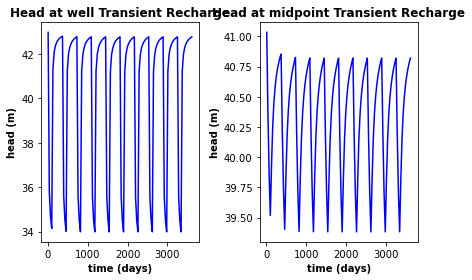

In [33]:
#extract time series at the well and at the center
time_series_well = headobj.get_ts((0,20,20))  # get the time series using flopy
center_point = (0, int(nrow/2), int(ncol/2)) #find the center of the domain
time_series_center = headobj.get_ts(center_point)


#Plot
plt.subplot(1, 2, 1)
plt.title("Head at well " + challenge, fontweight='bold')
plt.xlabel('time (days)', fontweight='bold')
plt.ylabel('head (m)', fontweight='bold')
plt.plot(time_series_well[:, 0], time_series_well[:, 1], 'b-')

plt.subplot(1, 2, 2)
plt.title("Head at midpoint "+ challenge, fontweight='bold')
plt.xlabel('time (days)', fontweight='bold')
plt.ylabel('head (m)', fontweight='bold')
plt.plot(time_series_center[:, 0], time_series_center[:, 1], 'b-')
plt.tight_layout()                    # add this line to fix the spacing between subplots
plt.savefig('well '+challenge)
plt.show()


### Plot a cross section through the well after the initial steady state, after finall off pumping period and at end of simulation

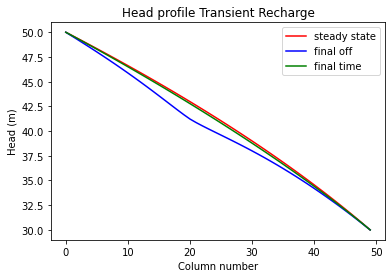

In [34]:
#plot head distribution at years 0, half of sim time, end of sim time
plt.plot(np.arange(nrow), head_array[0, 20, :], 'r', label='steady state')
plt.plot(np.arange(nrow), head_array[-9, 20, :], 'b', label='final off')
plt.plot(np.arange(nrow), head_array[-1, 20, :], 'g', label='final time')
plt.title('Head profile '+challenge)
plt.xlabel('Column number')
plt.ylabel('Head (m)')
plt.legend()
plt.savefig('head profile '+ challenge)

####  Plot countour heads at a given timestep

C:\Users\tento\Miniconda3\envs\gwmod\lib\site-packages\flopy\plot\map.py:819: DeprecationWarning: plot_discharge() has been deprecated and will be replaced in version 3.3.5. Use plot_vector() instead, which should follow after postprocessing.get_specific_discharge()
  warnings.warn(
C:\Users\tento\Miniconda3\envs\gwmod\lib\site-packages\flopy\plot\plotutil.py:1630: DeprecationWarning: centered_specific_discharge() has been deprecated and will be removed in version 3.3.5. Use postprocessing.get_specific_discharge() instead.
  warnings.warn(


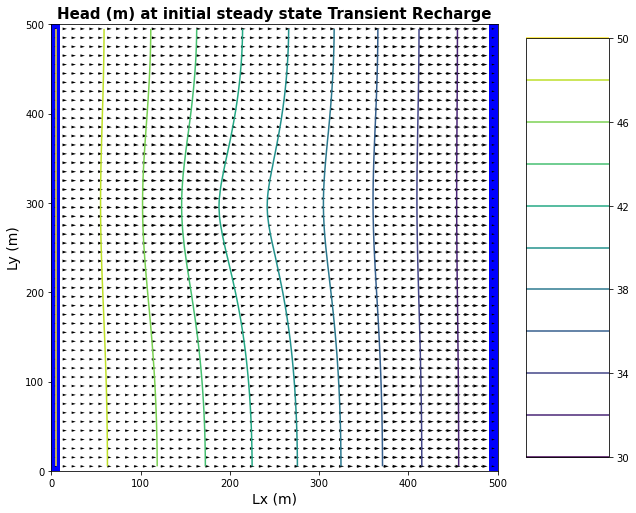

In [35]:
#plot first contour plot
time_select = -9     #index of the time you would like to plot

fig1 = plt.figure(figsize=(10, 10))  # create 10 x 10 figure
# use modelmap to attach plot to model
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
# grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()
# set contour levels for contouring head
contour_levels = np.linspace(head_array[0].min(), head_array[0].max(), 11)
head_contours = modelmap.contour_array(
    head_array[time_select, :, :], levels=contour_levels)  # create head contours
tempfrf3 = frf_array[time_select, :, :].reshape(1, ncol, nrow)
tempfff3 = fff_array[time_select, :, :].reshape(1, ncol, nrow)
temphead3 = head_array[time_select, :, :].reshape(1, ncol, nrow)
flows = modelmap.plot_discharge(
    tempfrf3, tempfff3, head=temphead3)  # create discharge arrows
plt.xlabel('Lx (m)', fontsize=14)
plt.ylabel('Ly (m)', fontsize=14)
plt.title('Head (m) at initial steady state '+challenge, fontsize=15, fontweight='bold')
plt.colorbar(head_contours, aspect=5)
plt.savefig('head contour '+challenge)
plt.show()


### Plot Drawdown

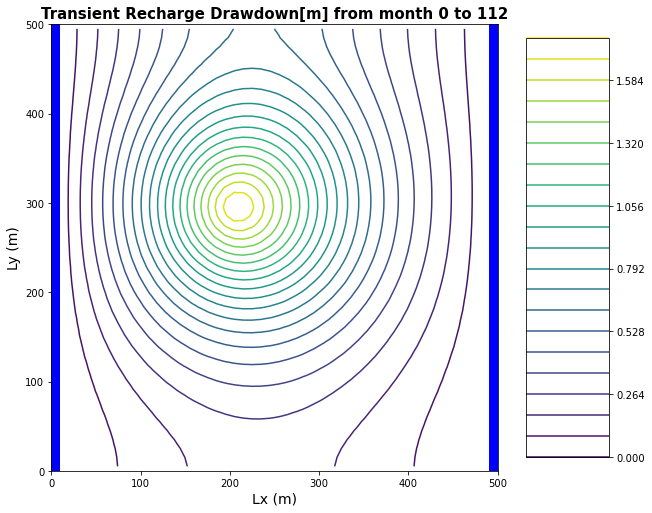

In [36]:
# Set two time indices to calculate the drawdown 
# Note1: Drawdown will be calculated as the head at time_select2 minus
#the head at time_select1
time_select1 = 0   #python index for the first head to be used
time_select2 = -9  #python index for the second head to be used
drawdown = head_array[time_select1, :, :]-head_array[time_select2, :, :]

#convert the time indices to the actual times and convert from days to months
time1 = (times[time_select1]-times[0])/30
time2 = (times[time_select2]-times[0])/30

#plot change in head distribution between steady state and final time
fig1 = plt.figure(figsize=(10, 10))  # create 10 x 10 figure
# use modelmap to attach plot to model
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
# grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()
contour_min = np.min(drawdown)
contour_max = np.max(drawdown)
# set contour levels for contouring head
contour_levels = np.linspace(contour_min, contour_max, 21)
head_contours = modelmap.contour_array(drawdown, levels=contour_levels)  # create head contours
plt.xlabel('Lx (m)', fontsize=14)
plt.ylabel('Ly (m)', fontsize=14)
title = challenge+' Drawdown[m] from month ' + str(int(time1)) + ' to ' + str(int(time2))
plt.title(title, fontsize=15, fontweight='bold')
plt.colorbar(head_contours, aspect=5)
plt.savefig('drawdown '+ challenge)
